Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- [**eli5**](https://eli5.readthedocs.io/en/latest/)
- matplotlib
- numpy
- pandas
- scikit-learn
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

We'll go back to Tanzania Waterpumps for this lesson.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')


# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [3]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [4]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8135521885521886


# Get permutation importances for model interpretation and feature selection

## Overview

Default Feature Importances are fast, but Permutation Importances may be more accurate.

These links go deeper with explanations and examples:

- Permutation Importances
  - [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
- (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

There are three types of feature importances:

### 1. (Default) Feature Importances

Fastest, good for first estimates, but be aware:



>**When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.** But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable. — [Selecting good features – Part III: random forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) 


 
 > **The scikit-learn Random Forest feature importance ... tends to inflate the importance of continuous or high-cardinality categorical variables.** ... Breiman and Cutler, the inventors of Random Forests, indicate that this method of “adding up the gini decreases for each individual variable over all trees in the forest gives a **fast** variable importance that is often very consistent with the permutation importance measure.” —  [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

 


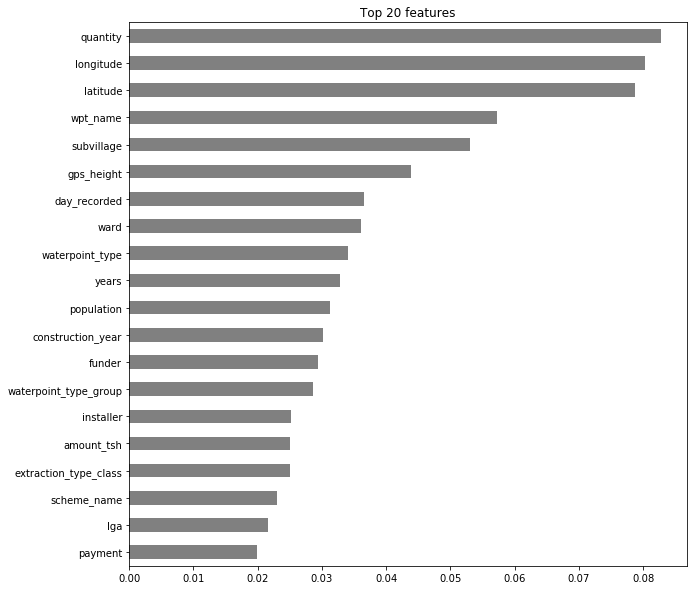

In [5]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### 2. Drop-Column Importance

The best in theory, but too slow in practice

In [6]:
column  = 'quantity'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without quantity: 0.7771043771043771
Validation Accuracy with quantity: 0.8135521885521886
Drop-Column Importance for quantity: 0.03644781144781151


### 3. Permutation Importance

Permutation Importance is a good compromise between Feature Importance based on impurity reduction (which is the fastest) and Drop Column Importance (which is the "best.")

[The ELI5 library documentation explains,](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)

> Importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.
>
> To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. ...
>
>To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.
>
>The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Do-It-Yourself way, for intuition

In [7]:
# How to permute of shuffle a column
# Before: sequence of feature to be permuted
feature = 'quantity'
X_val[feature].head()

3290     insufficient
47666    insufficient
2538           enough
53117          enough
51817          enough
Name: quantity, dtype: object

In [8]:
#before: dist

X_val[feature].value_counts()

enough          6619
insufficient    2976
dry             1325
seasonal         806
unknown          154
Name: quantity, dtype: int64

In [11]:
# shuffle time
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [12]:
# Check the sequence changed
X_val_permuted[feature].head()

3290     insufficient
47666             dry
2538         seasonal
53117          enough
51817    insufficient
Name: quantity, dtype: object

In [13]:
# AFter: Dist. Dist the same
X_val_permuted[feature].value_counts()

enough          6619
insufficient    2976
dry             1325
seasonal         806
unknown          154
Name: quantity, dtype: int64

In [17]:
# get permiuation importance, no refit needed
score_permuted = pipeline.score(X_val_permuted, y_val)
print('val acc with feature', score_with)
print(score_permuted)
print('diff:', (score_with - score_permuted))

val acc with feature 0.8135521885521886
0.7133838383838383
diff: 0.10016835016835024


In [18]:
# Rerun with diff feature

feature = 'wpt_name'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])
score_permuted = pipeline.score(X_val_permuted, y_val)
print('val acc with feature', score_with)
print(score_permuted)
print('diff:', (score_with - score_permuted))

val acc with feature 0.8135521885521886
0.8124579124579124
diff: 0.0010942760942761476


### With eli5 library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)
- [scikit-learn user guide, `scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

eli5 doesn't work with pipelines.

In [19]:
# Ignore warnings
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model =  RandomForestClassifier(n_estimators=100, random_state= 42)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring= 'accuracy',
    n_iter = 5,
    random_state=42

)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [25]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

basin                       -0.001431
quality_group               -0.000572
management_group            -0.000488
installer                   -0.000051
source_type                 -0.000017
construction_year_MISSING    0.000051
gps_height_MISSING           0.000051
latitude_MISSING             0.000135
population_MISSING           0.000202
year_recorded                0.000269
source_class                 0.000337
num_private                  0.000337
management                   0.000455
years_MISSING                0.000471
extraction_type              0.000539
water_quality                0.000539
ward                         0.000539
scheme_management            0.000657
lga                          0.000724
permit                       0.000774
scheme_name                  0.000808
longitude_MISSING            0.000875
region_code                  0.000892
region                       0.000926
wpt_name                     0.000943
month_recorded               0.001128
funder      

In [27]:
# 2. display permutaiton importances
eli5.show_weights(
    permuter,
    top=None, # number of features to show, no limit
    feature_names= feature_names, # must be a list
)

Weight,Feature
0.1016 ± 0.0029,quantity
0.0108 ± 0.0024,amount_tsh
0.0104 ± 0.0018,waterpoint_type
0.0102 ± 0.0015,extraction_type_class
0.0088 ± 0.0015,longitude
0.0068 ± 0.0018,waterpoint_type_group
0.0064 ± 0.0008,population
0.0062 ± 0.0026,latitude
0.0031 ± 0.0010,payment
0.0030 ± 0.0015,subvillage


### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [28]:
print('shape before remove', X_train.shape)

shape before remove (47520, 45)


In [36]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features= X_train.columns[mask]
X_train = X_train[features]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 45

In [38]:
# shape after
X_train.shape

(47520, 40)

In [40]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8117003367003367


# Use xgboost for gradient boosting

## Overview

In the Random Forest lesson, you learned this advice:

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or **Gradient Boosting** models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or **[boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw)** (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. **Gradient Boosting's advantage:** may get better predictive accuracy.

Like Random Forest, Gradient Boosting uses ensembles of trees. But the details of the ensembling technique are different:

### Understand the difference between boosting & bagging

Boosting (used by Gradient Boosting) is different than Bagging (used by Random Forests). 

Here's an excerpt from [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8.2.3, Boosting:

>Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model.
>
>**Boosting works in a similar way, except that the trees are grown _sequentially_: each tree is grown using information from previously grown trees.**
>
>Unlike fitting a single large decision tree to the data, which amounts to _fitting the data hard_ and potentially overfitting, the boosting approach instead _learns slowly._ Given the current model, we fit a decision tree to the residuals from the model.
>
>We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes. **By fitting small trees to the residuals, we slowly improve fˆ in areas where it does not perform well.**
>
>Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

This high-level overview is all you need to know for now. If you want to go deeper, we recommend you watch the StatQuest videos on gradient boosting!

Let's write some code. We have lots of options for which libraries to use:

#### Python libraries for Gradient Boosting
- [scikit-learn Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) — slower than other libraries, but [the new version may be better](https://twitter.com/amuellerml/status/1129443826945396737)
  - Anaconda: already installed
  - Google Colab: already installed
- [xgboost](https://xgboost.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
  - Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
  - Windows: `conda install -c anaconda py-xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed
- [CatBoost](https://catboost.ai/) — can accept missing values and use [categorical features](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html) without preprocessing
  - Anaconda: `conda install -c conda-forge catboost`
  - Google Colab: `pip install catboost`

In this lesson, you'll use a new library, xgboost — But it has an API that's almost the same as scikit-learn, so it won't be a hard adjustment!

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [43]:
from xgboost import XGBClassifier

In [44]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    # SimpleImputer(strategy='median'),  missing values accepted in this
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'wpt_name', 'subvillage',
                                      'region', 'lga', 'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'payment', 'water_quality', 'quantity',
                                      'source', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta

In [45]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('val accuracy:', accuracy_score(y_val,y_pred))

# not as good, because need to tune hyperparameters

val accuracy: 0.7457070707070707


#### [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

Why is early stopping better than a For loop, or GridSearchCV, to optimize `n_estimators`?

With early stopping, if `n_iterations` is our number of iterations, then we fit `n_iterations` decision trees.

With a for loop, or GridSearchCV, we'd fit `sum(range(1,n_rounds+1))` trees.

But it doesn't work well with pipelines. You may need to re-run multiple times with different values of other parameters such as `max_depth` and `learning_rate`.

#### XGBoost parameters
- [Notes on parameter tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
- [Parameters documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)


In [48]:
# Early stopping, 
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBClassifier(
    n_estimators= 1000, # up to 1000, depends on early stop
    max_depth = 7,
    learning_rate= 0.5, # try higher learning rate
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]
model.fit(X_train_encoded,y_train,
          eval_set = eval_set,
          eval_metric= 'merror', early_stopping_rounds = 50) #stop if score not improved in 50 rounds
    

[0]	validation_0-merror:0.250884	validation_1-merror:0.261953
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.234722	validation_1-merror:0.245791
[2]	validation_0-merror:0.229903	validation_1-merror:0.242424
[3]	validation_0-merror:0.225358	validation_1-merror:0.2383
[4]	validation_0-merror:0.216372	validation_1-merror:0.233249
[5]	validation_0-merror:0.209343	validation_1-merror:0.229714
[6]	validation_0-merror:0.204714	validation_1-merror:0.22601
[7]	validation_0-merror:0.198927	validation_1-merror:0.221549
[8]	validation_0-merror:0.194613	validation_1-merror:0.22037
[9]	validation_0-merror:0.191793	validation_1-merror:0.220286
[10]	validation_0-merror:0.189078	validation_1-merror:0.218603
[11]	validation_0-merror:0.18609	validation_1-merror:0.217256
[12]	validation_0-merror:0.182618	validation_1-merror:0.216919
[13]	validation_0-merror:0.180051

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

(0.18, 0.22)

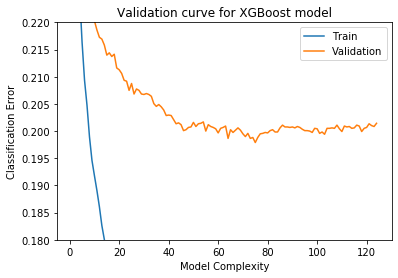

In [59]:
# PLot them
results = model.evals_result()
train_error = results['validation_0']['merror']
validation_error = results['validation_1']['merror']

epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label = "Train")
plt.plot(epoch, validation_error, label = 'Validation')
plt.ylabel("Classification Error")
plt.xlabel('Model Complexity')
plt.legend()
plt.title("Validation curve for XGBoost model")
plt.ylim((0.18,0.22)) # zoom

### Try adjusting these hyperparameters

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)

#### Xgboost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low, can try increasing)
- n_estimators (too low underfits, too high wastes time/overfits) — Use Early Stopping!
- learning_rate (too low underfits, too high overfits)

For more ideas, see [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).

## Challenge

You will use your portfolio project dataset for all assignments this sprint. Complete these tasks for your project, and document your work.

- Continue to clean and explore your data. Make exploratory visualizations.
- Fit a model. Does it beat your baseline?
- Try xgboost.
- Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, you can practice with another dataset instead. You may choose any dataset you've worked with previously.